In [1]:
from catchment import create_catchment, netcdf_from_dict
from tools import read_AsciiGrid, write_AsciiGrid
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from matplotlib import colors
from matplotlib.colors import LogNorm

today = date.today()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


catchment_mask
catchment_mask_bi
orig_dem
inflated_dem
flow_accumulation
slope
twi
soil
stream_mask
lake_mask
LAI_pine
LAI_spruce
LAI_conif
LAI_decid
canopy_fraction
canopy_height


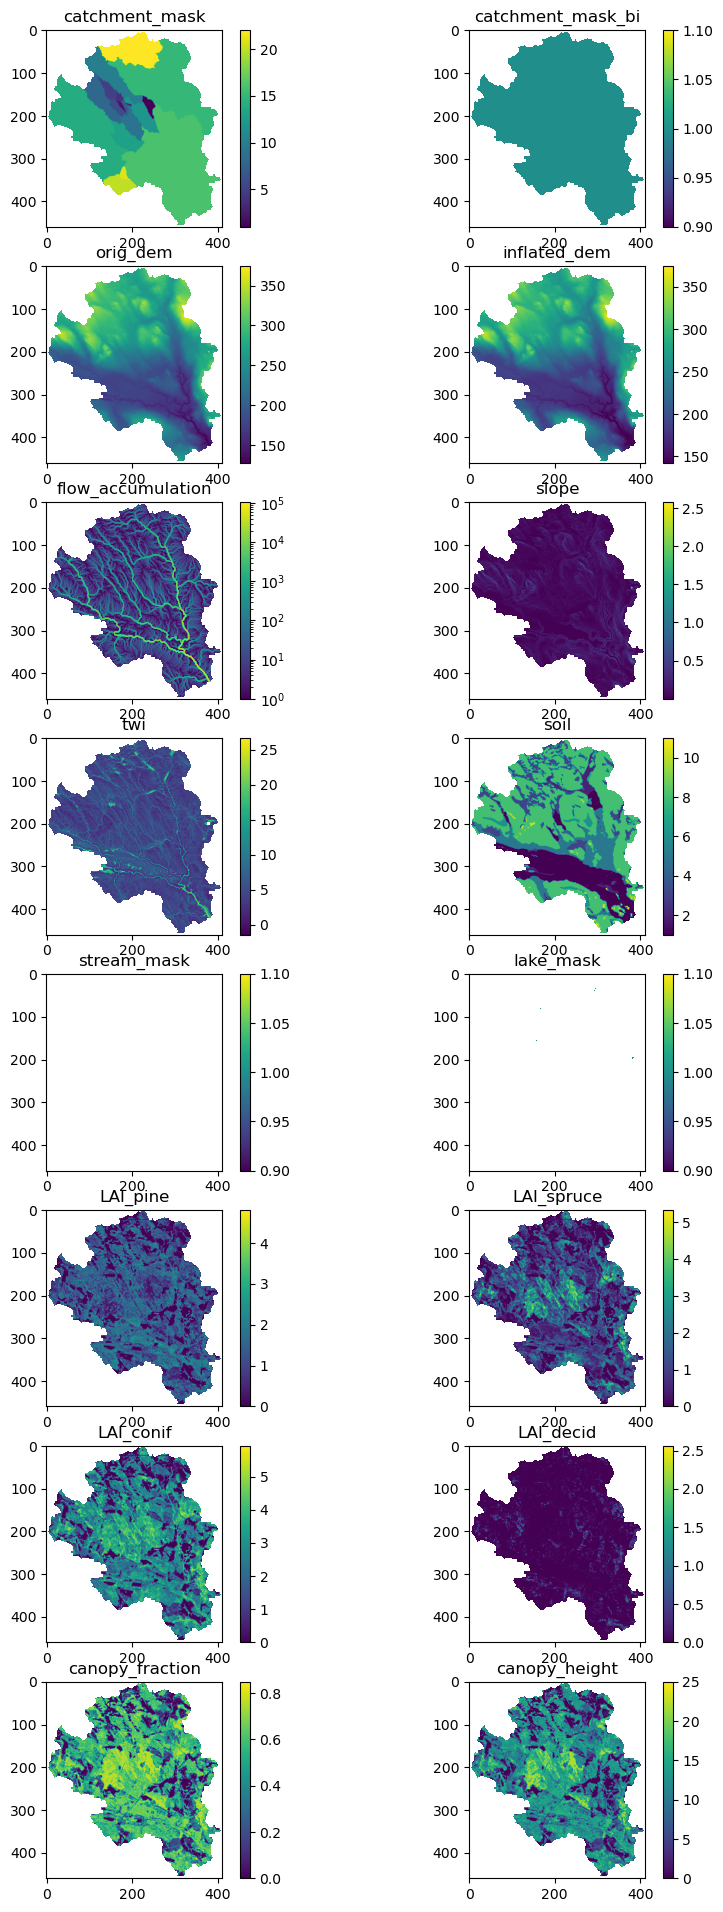

In [3]:
fpath = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/'
plotgrids = True

orig_dem, info, pos, cellsize, nodata = read_AsciiGrid(os.path.join(fpath, r'DEM/derivatives_0case/orig_dem.asc'))
inflated_dem, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'DEM/derivatives_0case/inflated_dem.asc'))
cmask, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'DEM/derivatives/cmask.asc'))
flowacc, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'DEM/derivatives_0case/acc_d8.asc'))
slope, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'DEM/derivatives_0case/slope_d8.asc'))
twi, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'DEM/derivatives_0case/twi_d8.asc'))
stream, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'DEM/derivatives_0case/streams_d8_5ha.asc'))
lake, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'SOIL/krycklan_QD/lake_mask.asc'))
topsoil, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'SOIL/krycklan_QD/krycklan_QD_J1_J2_final.asc'))

cf, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'SLU_FOREST_MAP_KRYCKLAN/2010_processed/canopy_fraction.asc'))  # canopy closure [%]
height, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'SLU_FOREST_MAP_KRYCKLAN/2010_processed/HEIGHT_XX_P_10.asc'))  
LAI_spruce, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'KRYCKLAN_LAI/processed/LAI_spruce.asc'))  
LAI_pine, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'KRYCKLAN_LAI/processed/LAI_pine.asc'))  
LAI_decid, _, _, _, _ = read_AsciiGrid(os.path.join(fpath, r'KRYCKLAN_LAI/processed/LAI_decid.asc'))  
LAI_conif = LAI_pine + LAI_spruce
cmask_bi = cmask.copy()
cmask_bi[np.isfinite(cmask_bi)] = 1.0
cmask_bi[~np.isfinite(cmask_bi)] = np.nan

stream_mask_bi = stream.copy()
stream_mask_bi[np.isfinite(stream_mask_bi)] = 1.0
stream_mask_bi[~np.isfinite(stream_mask_bi)] = 0.0

nrows, ncols = np.shape(orig_dem)
lon0 = np.arange(pos[0], pos[0] + cellsize*ncols, cellsize)
lat0 = np.arange(pos[1], pos[1] + cellsize*nrows, cellsize)
lat0 = np.flipud(lat0)  # why this is needed to get coordinates correct when plotting?

"""
Create soiltype grid and masks for waterbodies, streams, peatlands and rocks
"""

stream[np.isfinite(stream)] = 1.0
lake[np.isfinite(lake)] = 1.0
lake[topsoil == 7] = 1.0

# Use np.bincount to find the most common value to fill the nans
most_common_value = np.bincount(topsoil[np.isfinite(topsoil)].astype(int).flatten()).argmax()
topsoil[(~np.isfinite(topsoil)) & (np.isfinite(cmask))] = most_common_value

# catchment outlet location and catchment mean elevation
(iy, ix) = np.where(flowacc == np.nanmax(flowacc))
loc = {'lat': lat0[iy], 'lon': lon0[ix], 'elev': np.nanmean(orig_dem)}
# dict of all rasters
GisData = {'catchment_mask': cmask,
           'catchment_mask_bi': cmask_bi,
            'orig_dem': orig_dem, 
            'inflated_dem': inflated_dem, 
            'flow_accumulation': flowacc, 
            'slope': slope, 
            'twi': twi, 
            'soil': topsoil, 
            'stream_mask': stream,
            'lake_mask': lake,           
            'LAI_pine': LAI_pine, 
            'LAI_spruce': LAI_spruce, 
            'LAI_conif': LAI_pine + LAI_spruce, 
            'LAI_decid': LAI_decid,     
            'canopy_fraction': cf, 
            'canopy_height': height, 
            'cellsize': cellsize, 
            'info': info, 
            'lat0': lat0, 
            'lon0': lon0, 
            'loc': loc}

GisData_units = {}
GisData_meta = {}
            
if plotgrids is True:
    keys = GisData.keys()
    no_plot = ['cellsize', 'info', 'lat0', 'lon0', 'loc']
    figno = 0
    for var in keys:
        if var not in no_plot:
            figno += 1
    figcol = 2
    #figrow = int(figno/figcol)
    figrow = int(figno/figcol) + (figno%figcol > 0)
    figh = int(figrow*3)
    figw = 10
    fig, axs = plt.subplots(figsize=(figw, figh), nrows=figrow, ncols=figcol)

    for key, ax in zip(keys, axs.ravel()):
        if key not in ['cellsize', 'info', 'lat0', 'lon0', 'loc']:
            print(key)
            GisData[key] = GisData[key] * GisData['catchment_mask_bi']
            if key == 'flow_accumulation':
                im = ax.imshow(GisData[key], cmap='viridis', norm=colors.LogNorm())
                bar = plt.colorbar(im, ax=ax)
            else:
                im = ax.imshow(GisData[key], cmap='viridis')
                bar = plt.colorbar(im, ax=ax) 
            ax.set_title(key) 

    plt.show()

In [4]:
folder = r'/Users/jpnousu/SpaFHy_RUNS/krycklan/gis/25m_0case'
if not os.path.exists(folder):
    os.makedirs(folder)
variables = ['catchment_mask', 'inflated_dem', 'orig_dem', 'flow_accumulation', 'slope', 'twi', 
             'soil', 'stream_mask', 'lake_mask',
             'LAI_pine', 'LAI_spruce', 'LAI_conif', 'LAI_decid', 
             'canopy_height', 'canopy_fraction']
info = GisData['info']
for var in list(GisData.keys()):
    if var in variables:
        print(var)
        fname = os.path.join(folder, var) + '.asc'
        data = GisData[var]
        write_AsciiGrid(fname, data, info)

catchment_mask
orig_dem
inflated_dem
flow_accumulation
slope
twi
soil
stream_mask
lake_mask
LAI_pine
LAI_spruce
LAI_conif
LAI_decid
canopy_fraction
canopy_height
